In [1]:
import torch

if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [2]:
import os
import torch
import clip
import numpy as np
import pandas as pd
from PIL import Image
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt


C:\Users\samyu\Desktop\kiosk\kiosk\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Define data directory and file paths
data_dir = "../data"  # Adjust path as needed
classes_file = os.path.join(data_dir, "classes.txt")
attributes_file = os.path.join(data_dir, "predicates.txt")
attribute_matrix_file = os.path.join(data_dir, "predicate-matrix-binary.txt")

# Load classes
with open(classes_file, "r") as f:
    classes = [line.split("\t")[1].strip() for line in f.readlines()]

# Load attributes
with open(attributes_file, "r") as f:
    attributes = [line.split("\t")[1].strip() for line in f.readlines()]

# Load attribute matrix
attribute_matrix = pd.read_csv(attribute_matrix_file, sep=r'\s+', header=None)
attribute_matrix.columns = attributes
attribute_matrix.index = classes

# Check loaded data
print(f"Loaded {len(classes)} classes and {len(attributes)} attributes.")
print("Sample Classes:", classes[:5])
print("Sample Attributes:", attributes[:5])
print(f"Attribute Matrix Shape: {attribute_matrix.shape}")
pd.to_pickle(attribute_matrix, "attribute_matrix.pkl")


Loaded 50 classes and 85 attributes.
Sample Classes: ['antelope', 'grizzly+bear', 'killer+whale', 'beaver', 'dalmatian']
Sample Attributes: ['black', 'white', 'blue', 'brown', 'gray']
Attribute Matrix Shape: (50, 85)


In [4]:
# Set up device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load CLIP model
model_clip, preprocess = clip.load("ViT-B/32", device=device)


In [5]:
# Generate class embeddings
def generate_class_embeddings(classes):
    class_embeddings = {}
    with torch.no_grad():
        for class_name in classes:
            text_tokens = clip.tokenize([class_name]).to(device)
            embedding = model_clip.encode_text(text_tokens).cpu().numpy()
            class_embeddings[class_name] = embedding
    return class_embeddings

class_embeddings = generate_class_embeddings(classes)
torch.save(class_embeddings, "class_embeddings.pt")


In [6]:
# Generate attribute embeddings
def attribute_to_embedding_incremental(attributes, attribute_matrix, max_tokens=77):
    attribute_embeddings = {}
    with torch.no_grad():
        for index, class_name in enumerate(attribute_matrix.index):
            attribute_vector = attribute_matrix.iloc[index]
            selected_attributes = [attributes[i] for i, val in enumerate(attribute_vector) if val == 1]

            tokenized_attributes = {attr: clip.tokenize([attr])[0] for attr in selected_attributes}

            valid_attributes = []
            total_tokens = 0
            for attr, tokens in tokenized_attributes.items():
                if total_tokens + len(tokens) <= max_tokens:
                    valid_attributes.append(attr)
                    total_tokens += len(tokens)
                else:
                    break

            attribute_description = f"This animal is described as {', '.join(valid_attributes)}."
            text_tokens = clip.tokenize([attribute_description]).to(device)
            embedding = model_clip.encode_text(text_tokens).cpu().numpy()
            attribute_embeddings[class_name] = embedding
    return attribute_embeddings

attribute_embeddings = attribute_to_embedding_incremental(attributes, attribute_matrix)
torch.save(attribute_embeddings, "attribute_embeddings.pt")


In [7]:
# Combine embeddings
def align_embeddings(class_embeddings, attribute_embeddings):
    combined_embeddings = {}
    for class_name in class_embeddings.keys():
        visual_emb = class_embeddings[class_name]
        text_emb = attribute_embeddings[class_name]
        combined_emb = np.concatenate((visual_emb, text_emb), axis=1)
        combined_embeddings[class_name] = combined_emb
    return combined_embeddings

combined_embeddings = align_embeddings(class_embeddings, attribute_embeddings)
visual_embeddings = {class_name: embedding.flatten()[:512] for class_name, embedding in combined_embeddings.items()}
torch.save(combined_embeddings, "combined_embeddings.pt")
torch.save(visual_embeddings,"visual_embeddings.pt")


In [8]:
# Image embedding function
def generate_image_embedding(image_path):
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    with torch.no_grad():
        image_embedding = model_clip.encode_image(image).cpu().numpy().flatten()
    return image_embedding

# Zero-shot classification
def zero_shot_classification(image_embedding, visual_embeddings, class_names):
    similarities = []
    for class_name, visual_embedding in visual_embeddings.items():
        similarity = np.dot(image_embedding, visual_embedding) / (
            np.linalg.norm(image_embedding) * np.linalg.norm(visual_embedding)
        )
        similarities.append((class_name, similarity))

    return sorted(similarities, key=lambda x: x[1], reverse=True)[0]


In [9]:
def get_active_attributes(attribute_matrix, attributes, class_name):
    class_index = attribute_matrix.index.get_loc(class_name)
    attribute_vector = attribute_matrix.iloc[class_index]
    return [attributes[i] for i in range(len(attribute_vector)) if attribute_vector.iloc[i] == 1]


Predicted Class: leopard, Similarity Score: 0.2979
Attributes for leopard: ['black', 'brown', 'yellow', 'patches', 'spots', 'furry', 'big', 'lean', 'paws', 'longleg', 'tail', 'meatteeth', 'claws', 'walks', 'fast', 'strong', 'muscle', 'quadrapedal', 'active', 'nocturnal', 'agility', 'fish', 'meat', 'forager', 'hunter', 'stalker', 'newworld', 'oldworld', 'bush', 'plains', 'jungle', 'mountains', 'ground', 'tree', 'fierce', 'smart', 'solitary', 'nestspot']


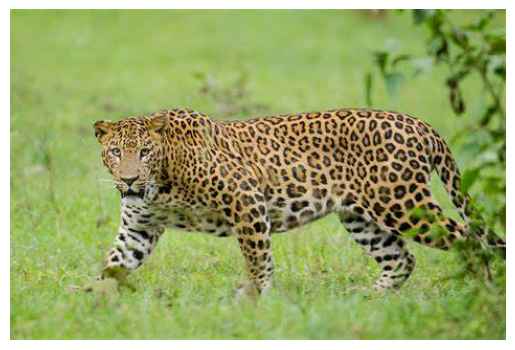

In [10]:
# Main execution
image_path = "../data/ele.jpg"  # Update this with your image path
image_embedding = generate_image_embedding(image_path)

predicted_class, score = zero_shot_classification(image_embedding, visual_embeddings, classes)
print(f"Predicted Class: {predicted_class}, Similarity Score: {score:.4f}")


active_attributes = get_active_attributes(attribute_matrix, attributes, predicted_class)
print(f"Attributes for {predicted_class}: {active_attributes}")

# Display the image
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()


In [11]:
import json

# Save active attributes to a JSON file
data_to_save = {
    "Predicted Class": predicted_class,
    "Active Attributes": active_attributes
}

with open("active_attributes.json", "w") as file:
    json.dump(data_to_save, file, indent=4)
print("Active attributes saved to 'active_attributes.json'")


Active attributes saved to 'active_attributes.json'


In [12]:
import os

# Directory containing subfolders for each class
images_dir = "../data/images"  # Update this path if needed

def evaluate_model(images_dir, visual_embeddings, classes):
    correct_predictions = 0
    total_images = 0

    for class_folder in os.listdir(images_dir):
        class_path = os.path.join(images_dir, class_folder)
        if not os.path.isdir(class_path):
            continue  # Skip non-folder files

        class_correct_predictions = 0
        class_total_images = 0

        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            # Skip non-image files
            if not (image_name.endswith('.jpg') or image_name.endswith('.png') or image_name.endswith('.jpeg')):
                continue

            # Generate embedding and predict class
            try:
                image_embedding = generate_image_embedding(image_path)
                predicted_class, _ = zero_shot_classification(image_embedding, visual_embeddings, classes)

                # Update counts for both overall and class-specific
                total_images += 1
                class_total_images += 1

                if predicted_class == class_folder:  # Compare predicted class with folder name
                    correct_predictions += 1
                    class_correct_predictions += 1

            except Exception as e:
                print(f"Error processing {image_path}: {e}")

        # Print accuracy for each folder
        if class_total_images > 0:
            class_accuracy = (class_correct_predictions / class_total_images) * 100
            print(f"Accuracy for {class_folder}: {class_accuracy:.2f}%")
            print(f"Correct Predictions for {class_folder}: {class_correct_predictions}/{class_total_images}")
        
    # Calculate overall accuracy
    accuracy = (correct_predictions / total_images) * 100 if total_images > 0 else 0
    return accuracy, correct_predictions, total_images

# Evaluate the model
accuracy, correct_predictions, total_images = evaluate_model(images_dir, visual_embeddings, classes)
print(f"\nOverall Accuracy: {accuracy:.2f}%")
print(f"Overall Correct Predictions: {correct_predictions}/{total_images}")


Accuracy for antelope: 93.40%
Correct Predictions for antelope: 977/1046
Accuracy for bat: 92.95%
Correct Predictions for bat: 356/383
Accuracy for beaver: 75.65%
Correct Predictions for beaver: 146/193
Accuracy for blue+whale: 1.15%
Correct Predictions for blue+whale: 2/174
Accuracy for bobcat: 96.83%
Correct Predictions for bobcat: 610/630
Accuracy for buffalo: 96.76%
Correct Predictions for buffalo: 866/895
Accuracy for chihuahua: 91.18%
Correct Predictions for chihuahua: 517/567
Accuracy for chimpanzee: 91.48%
Correct Predictions for chimpanzee: 666/728
Accuracy for collie: 92.80%
Correct Predictions for collie: 954/1028
Accuracy for cow: 87.67%
Correct Predictions for cow: 1173/1338
Accuracy for dalmatian: 97.45%
Correct Predictions for dalmatian: 535/549
Accuracy for deer: 91.52%
Correct Predictions for deer: 1230/1344
Accuracy for dolphin: 93.13%
Correct Predictions for dolphin: 881/946
Accuracy for elephant: 99.33%
Correct Predictions for elephant: 1031/1038
Accuracy for fox: 9